In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pyquadkey2 import quadkey
from shapely.geometry import Point, Polygon, MultiPolygon
import rasterio
from rasterio.plot import show
from scipy.ndimage import gaussian_filter
import rasterio.mask
from fiona import Env

In [27]:


def get_point_in_polygon(lat, lon, polygons):
    """
    @param lat: double
    @param lon: double
    @param polygons: dict
    @return geo_id: str
    """
    point = Point(lon, lat)
    for geo_id in polygons:
        polygon = polygons[geo_id]
        if isinstance(polygon, Polygon):
            if polygon.contains(point):
                return geo_id
        elif isinstance(polygon, MultiPolygon):
            for subpolygon in polygon.geoms:
                if subpolygon.contains(point):
                    return geo_id
    return 'null'


In [28]:
shapefile = gpd.read_file('/Users/kismatkhatri/Documents/Capstone project/shapefile/pak_admbnda_adm2_wfp_20220909.shp')
polygons = dict(zip(shapefile['ADM2_PCODE'], shapefile['geometry']))

print(shapefile.shape)
shapefile.head()

(160, 15)


,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,1.594116,0.067758,Bagh,PK101,None,None,None,Azad Kashmir,PK1,Pakistan,PK,2022-09-02,2022-09-09,None,"POLYGON ((73.53892 34.12617, 73.53952 34.12492..."
1,1.987888,0.117047,Bhimber,PK102,None,None,None,Azad Kashmir,PK1,Pakistan,PK,2022-09-02,2022-09-09,None,"POLYGON ((73.96443 33.24121, 73.96562 33.24077..."
2,1.300416,0.066683,Jhelum Valley,PK103,None,None,None,Azad Kashmir,PK1,Pakistan,PK,2022-09-02,2022-09-09,None,"POLYGON ((73.91993 34.34231, 73.94097 34.30174..."
3,1.001545,0.053722,Haveli,PK104,None,None,None,Azad Kashmir,PK1,Pakistan,PK,2022-09-02,2022-09-09,None,"POLYGON ((74.15687 34.04042, 74.16142 34.03887..."
4,2.017824,0.155069,Kotli,PK105,None,None,None,Azad Kashmir,PK1,Pakistan,PK,2022-09-02,2022-09-09,None,"POLYGON ((73.62197 33.65854, 73.62265 33.65844..."


In [29]:
rwi_df = pd.read_csv('/Users/kismatkhatri/Documents/Capstone project/joinedRWI_population.csv')
rwi_df.head()


,latitude,longitude,rwi,error,quadkey,population
0,33.897776,70.037842,-0.074,0.624,12310221130231,1190.728087
1,31.118794,66.807861,-0.569,0.368,12303111302200,99.496179
2,32.648625,73.245850,-0.193,0.498,12310322022121,5348.915150
3,35.182788,72.894287,-0.178,0.355,12310213112323,773.519400
4,25.948166,69.268799,-0.530,0.450,12312201232000,728.985542


In [30]:
rwi_df['geo_id'] = rwi_df.apply(lambda x: get_point_in_polygon(x['latitude'], x['longitude'], polygons), axis=1)
rwi_df = rwi_df[rwi_df['geo_id'] != 'null']

print(rwi_df.shape)
rwi_df.head()
 

(85643, 7)


,latitude,longitude,rwi,error,quadkey,population,geo_id
0,33.897776,70.037842,-0.074,0.624,12310221130231,1190.728087,PK518
1,31.118794,66.807861,-0.569,0.368,12303111302200,99.496179,PK235
2,32.648625,73.245850,-0.193,0.498,12310322022121,5348.915150,PK613
3,35.182788,72.894287,-0.178,0.355,12310213112323,773.519400,PK515
4,25.948166,69.268799,-0.530,0.450,12312201232000,728.985542,PK718


In [31]:
#rwi_df.to_csv('/Users/kismatkhatri/Documents/Capstone project/RWI_population_quadkey_geo_id.csv', index=False)

In [3]:
rwi_df = pd.read_csv('/Users/kismatkhatri/Documents/Capstone project/RWI_population_quadkey_geo_id.csv')
rwi_df.head()

,latitude,longitude,rwi,error,quadkey,population,geo_id
0,33.897776,70.037842,-0.074,0.624,12310221130231,1190.728087,PK518
1,31.118794,66.807861,-0.569,0.368,12303111302200,99.496179,PK235
2,32.648625,73.245850,-0.193,0.498,12310322022121,5348.915150,PK613
3,35.182788,72.894287,-0.178,0.355,12310213112323,773.519400,PK515
4,25.948166,69.268799,-0.530,0.450,12312201232000,728.985542,PK718


In [4]:
bing_tile_z14_pop = rwi_df.groupby('quadkey', as_index=False)['population'].sum()


In [5]:
geo_pop = rwi_df.groupby('geo_id', as_index=False)['population'].sum()


In [6]:
rwi_df = rwi_df.merge(bing_tile_z14_pop, on='quadkey', how='left')


In [7]:
rwi_df.columns

Index(['latitude', 'longitude', 'rwi', 'error', 'quadkey', 'population_x',
       'geo_id', 'population_y'],
      dtype='object')

In [8]:
rwi_df['population_x']

0        1190.728087
1          99.496179
2        5348.915150
3         773.519400
4         728.985542
            ...     
85638     122.458884
85639    4363.553928
85640     201.658053
85641     267.999888
85642    3443.343820
Name: population_x, Length: 85643, dtype: float64

In [9]:
rwi_df['population_y']

0        1190.728087
1          99.496179
2        5348.915150
3         773.519400
4         728.985542
            ...     
85638     122.458884
85639    4363.553928
85640     201.658053
85641     535.999776
85642    6886.687640
Name: population_y, Length: 85643, dtype: float64

In [10]:
geo_pop.columns

Index(['geo_id', 'population'], dtype='object')

In [11]:
rwi_df['pop_weight'] = rwi_df['population_y'] / rwi_df['geo_id'].map(geo_pop.set_index('geo_id')['population'])
rwi_df['rwi_weight'] = rwi_df['rwi'] * rwi_df['pop_weight']


In [12]:
rwi_df['rwi_weight']

0       -0.000128
1       -0.000293
2       -0.000675
3       -0.000641
4       -0.000181
           ...   
85638   -0.000169
85639    0.000701
85640   -0.000044
85641   -0.000061
85642   -0.002611
Name: rwi_weight, Length: 85643, dtype: float64

In [13]:
#rwi_df.to_csv('/Users/kismatkhatri/Documents/Capstone project/Weighted_RWI_with_lat_lon.csv', index=False)

In [14]:
geo_rwi = rwi_df.groupby('geo_id', as_index=False)['rwi_weight'].sum()


In [15]:
geo_rwi.head()

,geo_id,rwi_weight
0,PK101,0.050482
1,PK102,0.027296
2,PK103,0.021551
3,PK104,-0.263393
4,PK105,0.066787


##  i.	What is the distribution of relative wealth observed within districts? How much information is being lost by aggregating information at the district level? Does the concentration of the poorest differ given both indices?

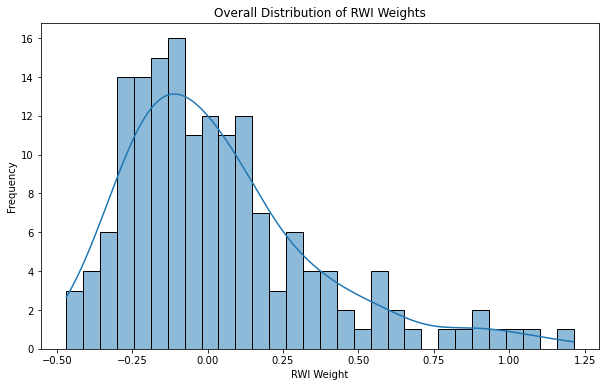

In [16]:

# Overall Distribution of RWI Weights
plt.figure(figsize=(10, 6))
sns.histplot(geo_rwi['rwi_weight'], bins=30, kde=True)
plt.title('Overall Distribution of RWI Weights')
plt.xlabel('RWI Weight')
plt.ylabel('Frequency')
plt.show()

In [17]:
# Statistical summary for the RWI weights across all districts
summary_stats = geo_rwi['rwi_weight'].describe()

In [18]:
# Display a statistical summary
print(summary_stats)



count    160.000000
mean       0.039244
std        0.322693
min       -0.468619
25%       -0.194072
50%       -0.037107
75%        0.173024
max        1.213413
Name: rwi_weight, dtype: float64


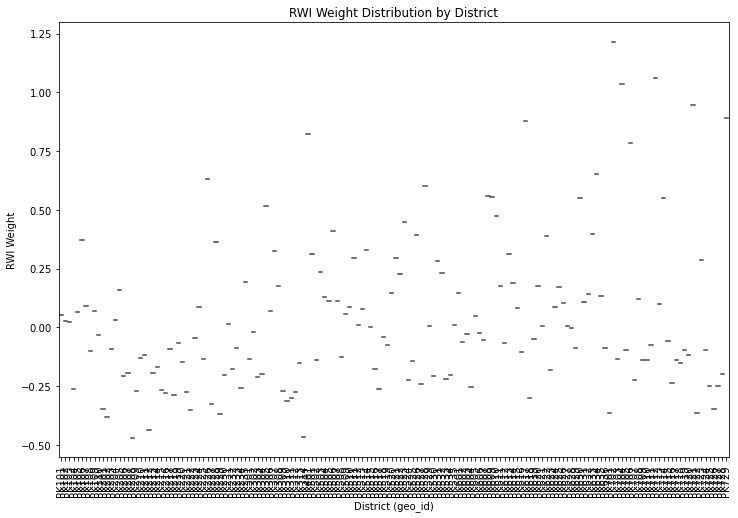

In [19]:

# Now, let's visualize the variation within each district using a violin plot,
# which is a better visual tool than a boxplot for understanding the distribution shape.
plt.figure(figsize=(12, 8))
sns.violinplot(x='geo_id', y='rwi_weight', data=geo_rwi)
plt.xticks(rotation=90)
plt.title('RWI Weight Distribution by District')
plt.xlabel('District (geo_id)')
plt.ylabel('RWI Weight')
plt.show()


In [20]:
# Concentration of the Poorest: Identifying areas with the lowest RWI scores
poorest_districts = geo_rwi.nsmallest(10, 'rwi_weight')  # Top 10 poorest by RWI weight

# Display the identified poorest districts
poorest_districts

,geo_id,rwi_weight
17,PK208,-0.468619
58,PK314,-0.466479
21,PK212,-0.434805
11,PK202,-0.380809
38,PK229,-0.368134
131,PK701,-0.363595
152,PK722,-0.362299
31,PK222,-0.352871
156,PK726,-0.347638
10,PK201,-0.346397


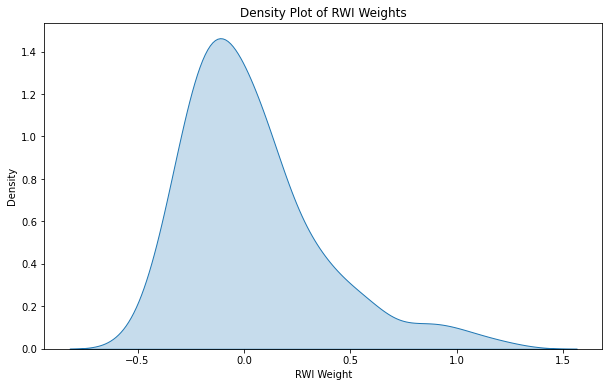

In [21]:
# Density Plot for RWI weights
plt.figure(figsize=(10, 6))
sns.kdeplot(geo_rwi['rwi_weight'], fill=True)
plt.title('Density Plot of RWI Weights')
plt.xlabel('RWI Weight')
plt.ylabel('Density')
plt.show()


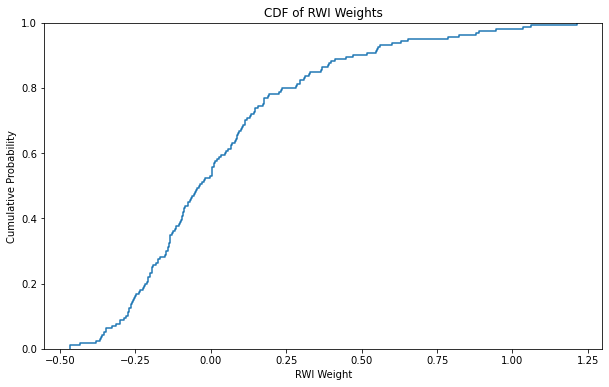

In [22]:
# Cumulative Distribution Function (CDF) for RWI weights
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=geo_rwi, x='rwi_weight')
plt.title('CDF of RWI Weights')
plt.xlabel('RWI Weight')
plt.ylabel('Cumulative Probability')
plt.show()


In [23]:
# Quantile Analysis
# Calculate the deciles of RWI weights
deciles = geo_rwi['rwi_weight'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])

# Display the deciles
print("Deciles of RWI Weights:")
print(deciles)

Deciles of RWI Weights:
0.1   -0.276878
0.2   -0.212699
0.3   -0.144137
0.4   -0.094395
0.5   -0.037107
0.6    0.048820
0.7    0.115802
0.8    0.246310
0.9    0.477394
Name: rwi_weight, dtype: float64


In [16]:
#geo_rwi.to_csv('/Users/kismatkhatri/Documents/Capstone project/Weighted_RWI_geo_id.csv', index=False)

## ii.	How the distribution of wealth varies within districts urban and rural areas?

In [33]:
# Function to map latitude and longitude to raster grid coordinates
def latlon_to_raster_coords(lat, lon, transform):
    row, col = ~transform * (lon, lat)
    return int(row), int(col)

# Function to map lat, lon to the DB urban classification
def map_to_db_class(lat, lon, urban_classification, transform, width, height):
    row, col = latlon_to_raster_coords(lat, lon, transform)
    if 0 <= row < height and 0 <= col < width:
        return urban_classification[row, col]
    else:
        return 0

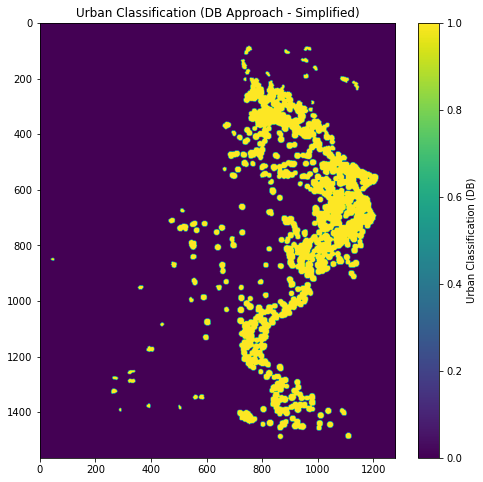

In [34]:


# Function to read raster data into a numpy array
def read_raster_data(file_path):
    with rasterio.open(file_path) as dataset:
        return dataset.read(1)  # Reading the first band

# Function to apply Gaussian smoothing (kernel smoothing) to a raster
def apply_smoothing(raster_data, sigma=1):
    return gaussian_filter(raster_data, sigma=sigma)

# Load and read the urbanization raster files
cc_path = '/Users/kismatkhatri/Documents/Capstone project/urban data/pak1k_gpod10b3000_cc.tif'
co_path = '/Users/kismatkhatri/Documents/Capstone project/urban data/pak1k_gpod10b3000_co.tif'
ct_path = '/Users/kismatkhatri/Documents/Capstone project/urban data/pak1k_gpod10b3000_ct.tif'
ur_path = '/Users/kismatkhatri/Documents/Capstone project/urban data/pak1k_gpod10b3000_ur.tif'

cc_data = read_raster_data(cc_path)
co_data = read_raster_data(co_path)
ct_data = read_raster_data(ct_path)
ur_data = read_raster_data(ur_path)

# Applying Gaussian smoothing to each raster dataset
smoothed_cc = apply_smoothing(cc_data)
smoothed_co = apply_smoothing(co_data)
smoothed_ct = apply_smoothing(ct_data)
smoothed_ur = apply_smoothing(ur_data)

# Compute a counterfactual threshold representing the 95th percentile of these densities
counterfactual_threshold = np.percentile(
    np.concatenate([smoothed_cc, smoothed_co, smoothed_ct, smoothed_ur]), 95
)

# Classifying areas based on the counterfactual threshold
urban_classification_db = np.zeros_like(smoothed_cc)
urban_classification_db[(smoothed_cc > counterfactual_threshold) |
                        (smoothed_co > counterfactual_threshold) |
                        (smoothed_ct > counterfactual_threshold) |
                        (smoothed_ur > counterfactual_threshold)] = 1

# Displaying the urban classification according to the simplified DB approach
plt.figure(figsize=(8, 8))
plt.imshow(urban_classification_db, cmap='viridis')
plt.colorbar(label='Urban Classification (DB)')
plt.title('Urban Classification (DB Approach - Simplified)')
plt.show()


In [35]:

# DOU thresholds
urban_threshold = 300  # people per km² for urban areas
high_density_urban_threshold = 1500  # people per km² for high-density urban areas

# Classify areas based on DOU criteria
rwi_df['dou_class'] = rwi_df['population_x'].apply(
    lambda x: 2 if x >= high_density_urban_threshold 
    else (1 if x >= urban_threshold else 0)
)

# Display the first few rows of the DataFrame with the new classification
print(rwi_df.head())


    latitude  longitude    rwi  error         quadkey  population_x geo_id  \
0  33.897776  70.037842 -0.074  0.624  12310221130231   1190.728087  PK518   
1  31.118794  66.807861 -0.569  0.368  12303111302200     99.496179  PK235   
2  32.648625  73.245850 -0.193  0.498  12310322022121   5348.915150  PK613   
3  35.182788  72.894287 -0.178  0.355  12310213112323    773.519400  PK515   
4  25.948166  69.268799 -0.530  0.450  12312201232000    728.985542  PK718   

   population_y  pop_weight  rwi_weight  dou_class  
0   1190.728087    0.001726   -0.000128          1  
1     99.496179    0.000515   -0.000293          0  
2   5348.915150    0.003497   -0.000675          2  
3    773.519400    0.003601   -0.000641          1  
4    728.985542    0.000342   -0.000181          1  


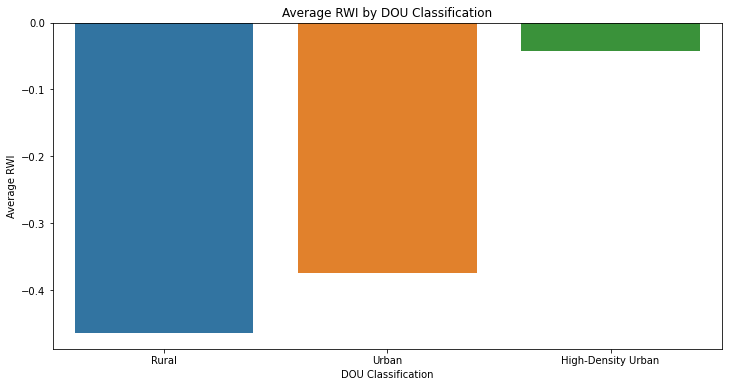

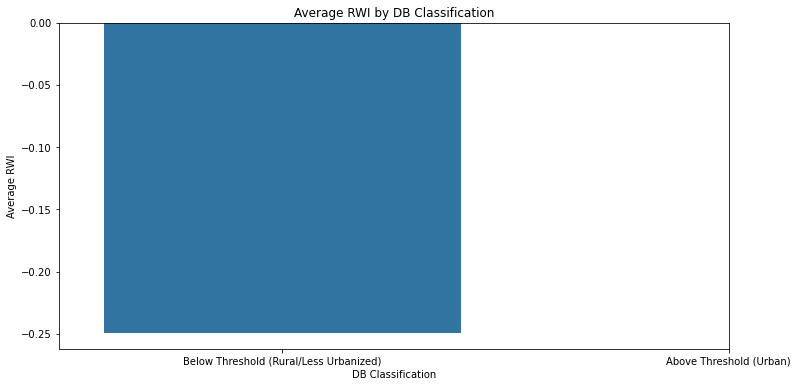

In [38]:
# Mapping DB urban classification to the RWI data
rwi_df['db_class'] = rwi_df.apply(
    lambda row: map_to_db_class(row['latitude'], row['longitude'], urban_classification_db, transform, width, height),
    axis=1
)

# Grouping by DOU and DB classification and calculating average RWI
rwi_by_dou_class = rwi_df.groupby('dou_class')['rwi'].mean().reset_index()
rwi_by_db_class = rwi_df.groupby('db_class')['rwi'].mean().reset_index()

# Visualization of RWI across DOU and DB classifications

# DOU classification visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='dou_class', y='rwi', data=rwi_by_dou_class)
plt.title('Average RWI by DOU Classification')
plt.xlabel('DOU Classification')
plt.ylabel('Average RWI')
plt.xticks(ticks=[0, 1, 2], labels=['Rural', 'Urban', 'High-Density Urban'])
plt.show()

# DB classification visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='db_class', y='rwi', data=rwi_by_db_class)
plt.title('Average RWI by DB Classification')
plt.xlabel('DB Classification')
plt.ylabel('Average RWI')
plt.xticks(ticks=[0, 1], labels=['Below Threshold (Rural/Less Urbanized)', 'Above Threshold (Urban)'])
plt.show()

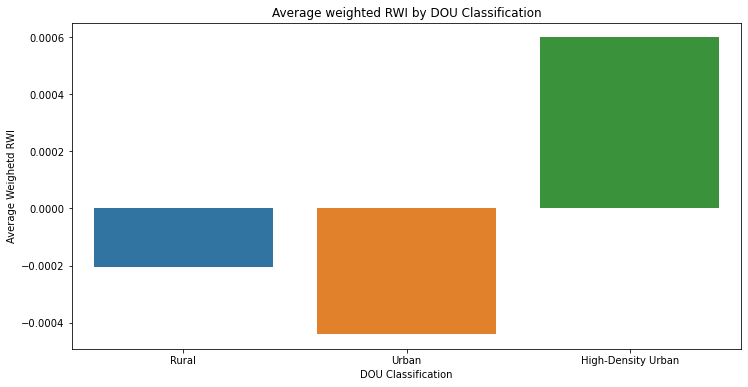

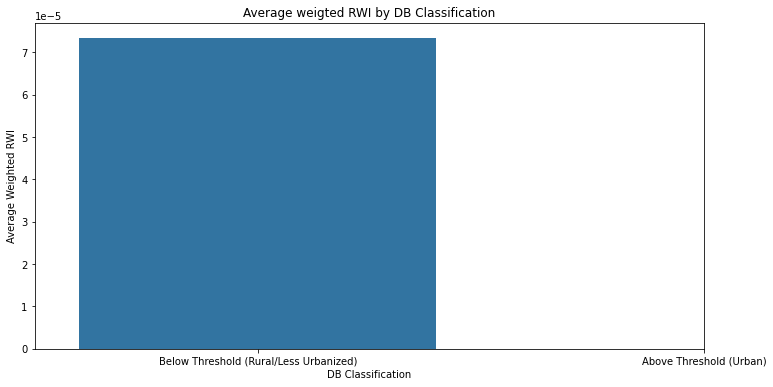

In [39]:
# Mapping DB urban classification to the RWI data
rwi_df['db_class'] = rwi_df.apply(
    lambda row: map_to_db_class(row['latitude'], row['longitude'], urban_classification_db, transform, width, height),
    axis=1
)

# Grouping by DOU and DB classification and calculating average RWI
rwi_by_dou_class = rwi_df.groupby('dou_class')['rwi_weight'].mean().reset_index()
rwi_by_db_class = rwi_df.groupby('db_class')['rwi_weight'].mean().reset_index()

# Visualization of RWI across DOU and DB classifications

# DOU classification visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='dou_class', y='rwi_weight', data=rwi_by_dou_class)
plt.title('Average weighted RWI by DOU Classification')
plt.xlabel('DOU Classification')
plt.ylabel('Average Weighetd RWI')
plt.xticks(ticks=[0, 1, 2], labels=['Rural', 'Urban', 'High-Density Urban'])
plt.show()

# DB classification visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='db_class', y='rwi_weight', data=rwi_by_db_class)
plt.title('Average weigted RWI by DB Classification')
plt.xlabel('DB Classification')
plt.ylabel('Average Weighted RWI')
plt.xticks(ticks=[0, 1], labels=['Below Threshold (Rural/Less Urbanized)', 'Above Threshold (Urban)'])
plt.show()

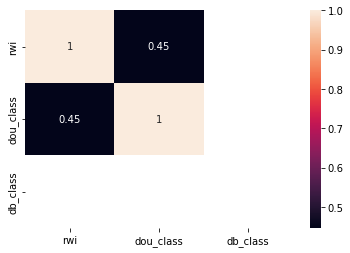

In [40]:
# Example: Correlation matrix
correlation_matrix = rwi_df[['rwi', 'dou_class', 'db_class']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()


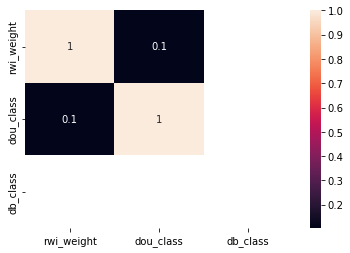

In [41]:
# Example: Correlation matrix
correlation_matrix = rwi_df[['rwi_weight', 'dou_class', 'db_class']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()


In [42]:
import statsmodels.api as sm

# Assuming rwi_df is your DataFrame and it includes 'rwi', 'dou_class', and 'db_class'

# Preparing the data for regression
X = rwi_df[['dou_class', 'db_class']]  # Independent variables
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = rwi_df['rwi']  # Dependent variable

# Building the regression model
model = sm.OLS(y, X).fit()

# Viewing the summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    rwi   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                 2.131e+04
Date:                Wed, 22 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:06:10   Log-Likelihood:                -33197.
No. Observations:               85643   AIC:                         6.640e+04
Df Residuals:                   85641   BIC:                         6.642e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5200      0.002   -234.473      0.0

/Users/kismatkhatri/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [43]:
import statsmodels.api as sm

# Assuming rwi_df is your DataFrame and it includes 'rwi', 'dou_class', and 'db_class'

# Preparing the data for regression
X = rwi_df[['dou_class', 'db_class']]  # Independent variables
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = rwi_df['rwi_weight']  # Dependent variable

# Building the regression model
model = sm.OLS(y, X).fit()

# Viewing the summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             rwi_weight   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     935.1
Date:                Wed, 22 Nov 2023   Prob (F-statistic):          2.91e-204
Time:                        16:06:35   Log-Likelihood:             3.6102e+05
No. Observations:               85643   AIC:                        -7.220e+05
Df Residuals:                   85641   BIC:                        -7.220e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005   2.22e-05    -22.254      0.0

/Users/kismatkhatri/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Preparing the data for regression
X = rwi_df[['dou_class', 'db_class']]  # Independent variables
y = rwi_df['rwi']  # Dependent variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Building the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.12403656884854186
R-squared: 0.19791107666244645


In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Preparing the data for regression
X = rwi_df[['dou_class', 'db_class']]  # Independent variables
y = rwi_df['rwi_weight']  # Dependent variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Building the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 9.03127849273747e-06
R-squared: 0.012137982440640127


## iii.	Simulating the targeting of social programs to understand the performance of the RWI. Does the RWI targeting properly predicts where the poorest X% of the population resides? 

In [48]:
Pslm_data = pd.read_stata('/Users/kismatkhatri/Documents/Capstone project/310_PSLM201920_Rescaledbyhhsize_160654obs.dta')
variables_list1 = [
    "W_dkw_inspiped",
    "W_dkw_inshandpump",
    "W_dkw_insmotorpump",
    "W_dkw_insclosedwell",
    "W_dkw_insopenwell",
    "W_dkw_insprotsprng",
    "W_dkw_insunprsprng",
    "W_dkw_outpiped",
    "W_dkw_outhandpump",
    "W_dkw_outmotorpump",
    "W_dkw_outclosedwell",
    "W_dkw_outopenwell",
    "W_dkw_outprotsprng",
    "W_dkw_outunprsprng",
    "W_dkw_pond",
    "W_dkw_bottwater",
    "W_dkw_tanker",
    "W_dkw_filtration",
    "W_dkw_other",
    "W_toilet_notoilet",
    "W_toilet_flushpub",
    "W_toilet_flushtank",
    "W_toilet_flushpit",
    "W_toilet_flushopen",
    "W_toilet_raiselat",
    "W_toilet_pitlat",
    "W_toilet_other",
    "W_toiletshared",
    "W_toiletprivate",
    "H_cooking_firewood",
    "H_cooking_gas",
    "H_cooking_lpg",
    "H_cooking_dung",
    "H_cooking_crop",
    "H_cooking_other",
    "H_floor_earth",
    "H_floor_ceramic",
    "H_floor_cement",
    "H_floor_bricks",
    "H_floor_other",
    "H_roof_rccrbc",
    "H_roof_wood",
    "H_roof_sheet",
    "H_roof_grader",
    "H_roof_other",
    "H_walls_burntbricks",
    "H_walls_mudbricks",
    "H_walls_wood",
    "H_walls_stones",
    "H_walls_other",
    "D_iradio",
    "D_itelevsion",
    "D_ilcdled",
    "D_irefrigerator",
    "D_ifreezer",
    "D_iwashing",
    "D_idryer",
    "D_iairconditioning",
    "D_iaircooler",
    "D_ifan",
    "D_istove",
    "D_icookingrange",
    "D_imicrowave",
    "D_isewingmachine",
    "D_iknitting",
    "D_iiron",
    "D_iwaterfilter",
    "D_idonkeypump",
    "D_iturbine",
    "D_ichair",
    "D_itable",
    "D_iups",
    "D_igenerator",
    "D_isolarpanel",
    "D_iheater",
    "D_igeaser",
    "D_ibicycle",
    "D_imotorcyclescotter",
    "D_irichshaw",
    "D_icar",
    "D_ivantruckbus",
    "D_iboat",
    "D_itractortralloy",
    "D_iclock"
]

In [50]:

# Step 1: Extract the selected columns and drop rows with missing values
selected_variables = Pslm_data[variables_list1].dropna().reset_index(drop=True)

# Step 2: Perform Min-Max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(selected_variables)

# Step 3: Calculate the square root of weights and adjust the scaled data
weights = Pslm_data.loc[selected_variables.index, 'popwt']
sqrt_weights = np.sqrt(weights)

# This ensures that the weights are applied to each observation
weighted_data = scaled_data * sqrt_weights[:, None]  # Using None instead of np.newaxis to avoid the warning

# Step 4: Apply PCA on the weighted data
pca = PCA(n_components=1)
pca.fit(weighted_data)

# Multiply the PCA components by the square root of the eigenvalues if necessary
components = pca.transform(weighted_data) * np.sqrt(pca.explained_variance_)

# Step 5: Analyze the PCA output
explained_variance = pca.explained_variance_ratio_[0]
print(f'PCA variance explained: {explained_variance * 100:.2f}%')

# Create the basis vector DataFrame
basis_vector = pd.DataFrame(pca.components_.T, index=variables_list1, columns=['Magnitude'])

# Sort the basis vector by magnitude in descending order
basis_vector.sort_values(by='Magnitude', ascending=False, inplace=True)

# Normalize the wealth index if necessary to match the expected range
wealth_index = components.squeeze()
min_max_scaler = MinMaxScaler(feature_range=(-2, 2))
Pslm_data['Wealth_Index1'] = min_max_scaler.fit_transform(wealth_index.reshape(-1, 1))

# Save the basis vector and updated DataFrame to CSV files
basis_vector.to_csv('PSLM_DATA_with_basis_vector.csv')
Pslm_data.to_csv('PSLM_data_with_wealth_index.csv', index=False)


/var/folders/zg/n2c3c7jj1t5dv6zbxjqxzbnc0000gn/T/ipykernel_946/3280395455.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  weighted_data = scaled_data * sqrt_weights[:, None]  # Using None instead of np.newaxis to avoid the warning


PCA variance explained: 25.60%


In [51]:
pslm_data = pd.read_csv("PSLM_data_with_wealth_index.csv")
pslm_district_wealth = pslm_data.groupby('District').agg({
    'Wealth_Index1': 'mean',
    'popwt': 'sum'
}).reset_index()

In [52]:
# Create a mapping dictionary for district names
district_mapping = {
    'Central Karachi': 'Karachi Central',
    'Chitral Lower': 'Chitral',
    'Chitral Upper': 'Chitral',
    'D. I. Khan': 'Dera Ismail Khan',
    'East Karachi': 'Karachi East',
    'Kashmore': 'Kashmor',
    'Kohistan Lower': 'Kohistan',
    'Kohistan Upper': 'Kohistan',
    'Korangi Karachi': 'Korangi',
    'Leiah': 'Layyah',
    'Malakand': 'Malakand Protected Area',
    'Malir Karachi': 'Malir',
    'Shaheed Benazir Abad': 'Shaheed Benazirabad',
    'South Karachi': 'Karachi South',
    'Tor Ghar': 'Torghar',
    'West Karachi': 'Karachi West',
    'Shaheed Sikandarabad': 'Surab'
}


In [54]:
# Load districts shapefile with environment settings to restore .shx index files
with Env(SHAPE_RESTORE_SHX='YES'):
    districts = gpd.read_file('/Users/kismatkhatri/Documents/Capstone project/shapefile/pak_admbnda_adm2_wfp_20220909.shp')

# Convert RWI data into GeoDataFrame
geometry = [Point(xy) for xy in zip(rwi_df['longitude'], rwi_df['latitude'])]
rwi_df = gpd.GeoDataFrame(rwi_df, geometry=geometry)

# Ensure CRS match
rwi_df.crs = districts.crs

# Perform the spatial join to associate RWI data with districts
rwi_data_with_district = gpd.sjoin(rwi_df, districts, how="left", op="within")

# Filter RWI data by specified provinces
provinces_to_include = ["Punjab", "Sindh", "Balochistan", "Khyber Pakhtunkhwa", "Islamabad"]
filtered_rwi_district_data = rwi_data_with_district[rwi_data_with_district['ADM1_EN'].isin(provinces_to_include)]

# Apply the mapping dictionary to the 'ADM2_EN' column of the filtered_rwi_district_data dataframe
filtered_rwi_district_data['ADM2_EN'] = filtered_rwi_district_data['ADM2_EN'].replace(district_mapping)


# Display column names in filtered_rwi_district_data
column_names_filtered_rwi = filtered_rwi_district_data.columns
print("Column Names in filtered_rwi_district_data:")
print(column_names_filtered_rwi)


/Users/kismatkhatri/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Column Names in filtered_rwi_district_data:
Index(['latitude', 'longitude', 'rwi', 'error', 'quadkey', 'population_x',
       'geo_id', 'population_y', 'pop_weight', 'rwi_weight', 'dou_class',
       'db_class', 'geometry', 'index_right', 'Shape_Leng', 'Shape_Area',
       'ADM2_EN', 'ADM2_PCODE', 'ADM2_REF', 'ADM2ALT1EN', 'ADM2ALT2EN',
       'ADM1_EN', 'ADM1_PCODE', 'ADM0_EN', 'ADM0_PCODE', 'date', 'validOn',
       'validTo'],
      dtype='object')


/Users/kismatkhatri/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [56]:
# Aggregate RWI data by district, now including all variables
agg_dict = {
    'rwi': 'mean',
    'population_x': 'sum',
    
}

filtered_rwi_district_data_agg = filtered_rwi_district_data.groupby('ADM2_EN').agg(agg_dict).reset_index()

In [57]:
# Sort districts by wealth index from PSLM and RWI
pslm_sorted = pslm_district_wealth.sort_values('Wealth_Index1').reset_index(drop=True)
rwi_sorted = filtered_rwi_district_data_agg.sort_values('rwi').reset_index(drop=True)

population_threshold = 0.14 * rwi_sorted ['population_x'].sum()  

# Initialize targeted districts lists
targeted_districts_pslm = []
targeted_districts_rwi = []

# Initialize population counters
population_counter_pslm = 0
population_counter_rwi = 0

# Target districts until the population threshold is reached for RWI
for index, row in rwi_sorted.iterrows():
    if population_counter_rwi + row['population_x'] <= population_threshold:
        targeted_districts_rwi.append(row['ADM2_EN'])
        population_counter_rwi += row['population_x']
    else:
        break

# Target districts until the population threshold is reached for PSLM, using 'popwt' as the population proxy
for index, row in pslm_sorted.iterrows():
    if population_counter_pslm + row['popwt'] <= population_threshold:
        targeted_districts_pslm.append(row['District'])
        population_counter_pslm += row['popwt']
    else:
        break

# Calculate performance metrics
true_positives = set(targeted_districts_pslm).intersection(set(targeted_districts_rwi))
precision = len(true_positives) / len(targeted_districts_rwi) if targeted_districts_rwi else 0
recall = len(true_positives) / len(targeted_districts_pslm) if targeted_districts_pslm else 0

# Output the performance
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Precision: 0.63
Recall: 0.67


In [58]:

# Calculate the set of all districts
all_districts = set(pslm_data['District'])

# Calculate inclusion and exclusion errors
incorrectly_included = set(targeted_districts_rwi) - set(targeted_districts_pslm)
incorrectly_excluded = set(targeted_districts_pslm) - set(targeted_districts_rwi)

# Error rates
inclusion_error = len(incorrectly_included) / len(all_districts)
exclusion_error = len(incorrectly_excluded) / len(all_districts)

# Print out the errors
print(f"Inclusion Error: {inclusion_error:.2f}")
print(f"Exclusion Error: {exclusion_error:.2f}")


Inclusion Error: 0.13
Exclusion Error: 0.11


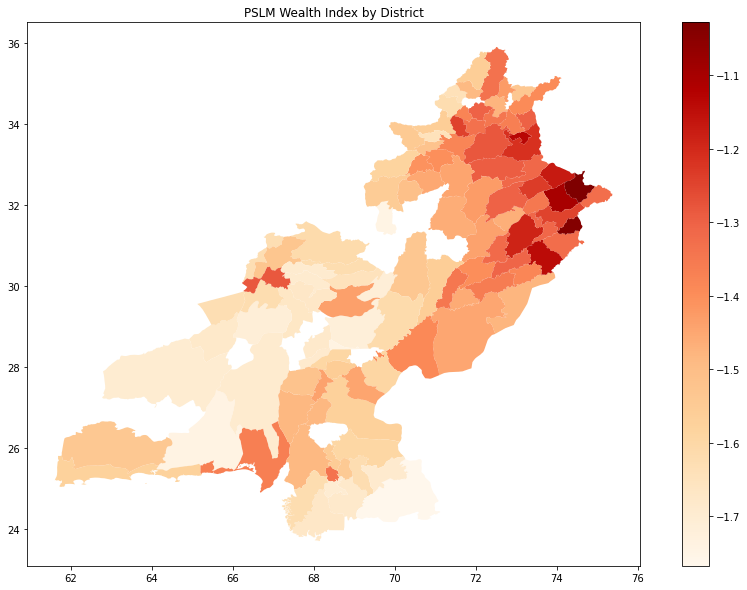

In [59]:
# Merge PSLM data with the shapefile
pslm_geo = districts.merge(pslm_district_wealth, left_on='ADM2_EN', right_on='District', how='left')

# Visualize the PSLM data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
pslm_geo.plot(column='Wealth_Index1', ax=ax, legend=True, cmap='OrRd')
plt.title('PSLM Wealth Index by District')
plt.show()

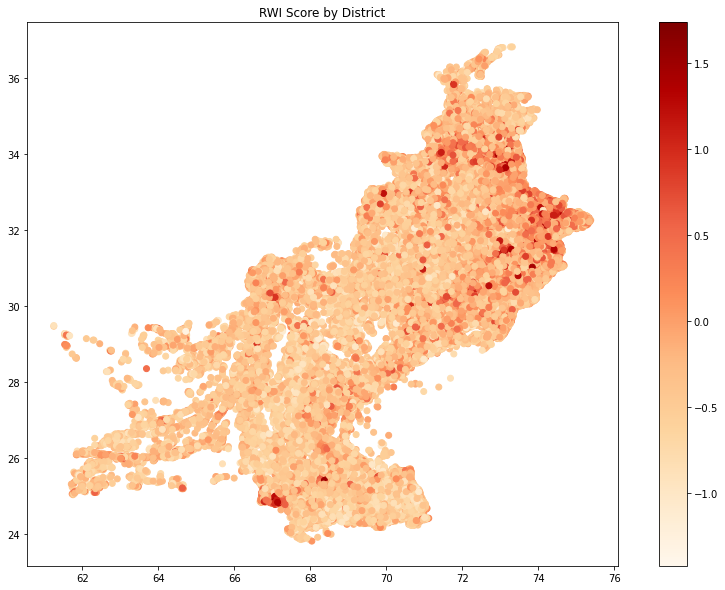

In [60]:
# For RWI data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
filtered_rwi_district_data.plot(column='rwi', ax=ax, legend=True, cmap='OrRd')
plt.title('RWI Score by District')
plt.show()

In [61]:
# Aggregate RWI data by district, now including all variables
agg_dict = {
    'rwi_weight': 'mean',
    'population_x': 'sum',
    
}

filtered_rwi_district_data_agg2 = filtered_rwi_district_data.groupby('ADM2_EN').agg(agg_dict).reset_index()

In [62]:
# Sort districts by wealth index from PSLM and RWI
pslm_sorted = pslm_district_wealth.sort_values('Wealth_Index1').reset_index(drop=True)
rwi_sorted = filtered_rwi_district_data_agg2.sort_values('rwi_weight').reset_index(drop=True)

population_threshold = 0.14 * rwi_sorted ['population_x'].sum()  

# Initialize targeted districts lists
targeted_districts_pslm = []
targeted_districts_rwi = []

# Initialize population counters
population_counter_pslm = 0
population_counter_rwi = 0

# Target districts until the population threshold is reached for RWI
for index, row in rwi_sorted.iterrows():
    if population_counter_rwi + row['population_x'] <= population_threshold:
        targeted_districts_rwi.append(row['ADM2_EN'])
        population_counter_rwi += row['population_x']
    else:
        break

# Target districts until the population threshold is reached for PSLM, using 'popwt' as the population proxy
for index, row in pslm_sorted.iterrows():
    if population_counter_pslm + row['popwt'] <= population_threshold:
        targeted_districts_pslm.append(row['District'])
        population_counter_pslm += row['popwt']
    else:
        break

# Calculate performance metrics
true_positives = set(targeted_districts_pslm).intersection(set(targeted_districts_rwi))
precision = len(true_positives) / len(targeted_districts_rwi) if targeted_districts_rwi else 0
recall = len(true_positives) / len(targeted_districts_pslm) if targeted_districts_pslm else 0

# Output the performance
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Precision: 0.65
Recall: 0.77


In [63]:

# Calculate the set of all districts
all_districts = set(pslm_data['District'])

# Calculate inclusion and exclusion errors
incorrectly_included = set(targeted_districts_rwi) - set(targeted_districts_pslm)
incorrectly_excluded = set(targeted_districts_pslm) - set(targeted_districts_rwi)

# Error rates
inclusion_error = len(incorrectly_included) / len(all_districts)
exclusion_error = len(incorrectly_excluded) / len(all_districts)

# Print out the errors
print(f"Inclusion Error: {inclusion_error:.2f}")
print(f"Exclusion Error: {exclusion_error:.2f}")


Inclusion Error: 0.14
Exclusion Error: 0.08


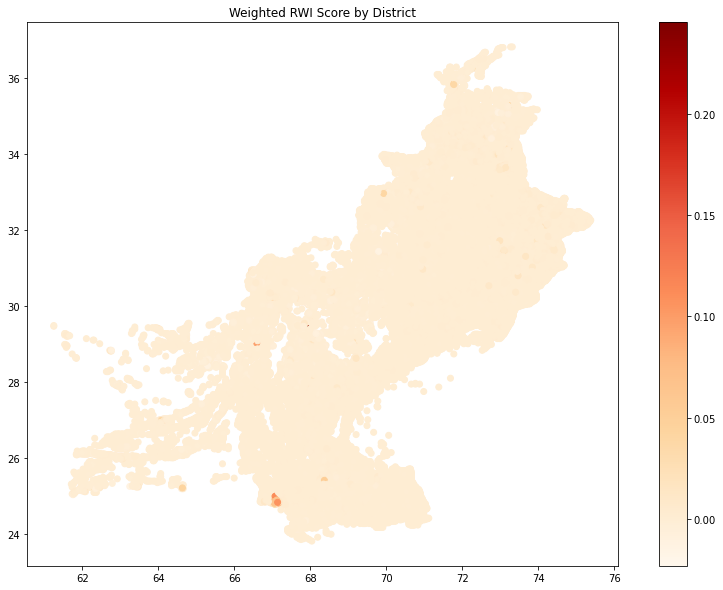

In [65]:
# For RWI data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
filtered_rwi_district_data.plot(column='rwi_weight', ax=ax, legend=True, cmap='OrRd')
plt.title('Weighted RWI Score by District')
plt.show()

/Users/kismatkhatri/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Index(['Shape_Leng', 'Shape_Area', 'ADM2_EN', 'ADM2_PCODE', 'ADM2_REF',
       'ADM2ALT1EN', 'ADM2ALT2EN', 'ADM1_EN', 'ADM1_PCODE', 'ADM0_EN',
       'ADM0_PCODE', 'date', 'validOn', 'validTo', 'geometry',
       'poorest_percentage_rwi', 'District', 'poorest_percentage_pslm'],
      dtype='object')


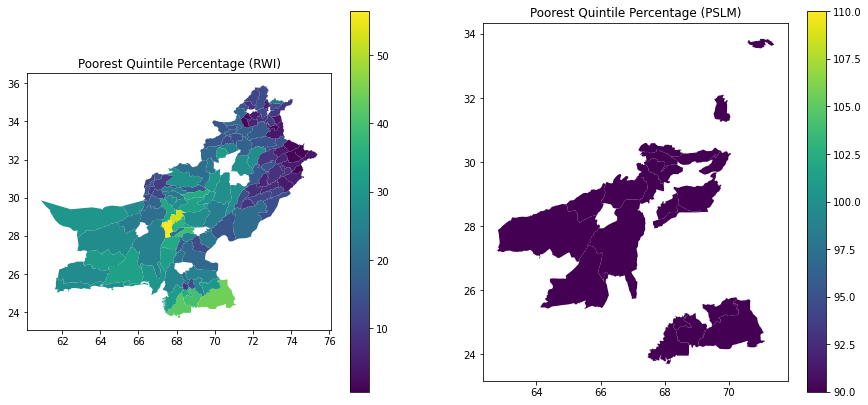

In [69]:

# Function to calculate the percentage of the poorest quintile in each regency
def calculate_poorest_quintile_percentage(df, wealth_column, regency_column):
    df['quintile'] = df[wealth_column].rank(pct=True) // 0.2 + 1
    poorest_df = df[df['quintile'] == 1]
    percentage_df = poorest_df.groupby(regency_column).size() / df.groupby(regency_column).size() * 100
    return percentage_df.reset_index(name='poorest_percentage')

# Calculate the poorest quintile percentage for both RWI and PSLM
rwi_poorest_percentage = calculate_poorest_quintile_percentage(filtered_rwi_district_data, 'rwi', 'ADM2_EN')
PSlm_poorest_percentage = calculate_poorest_quintile_percentage(pslm_district_wealth, 'Wealth_Index1', 'District')



# Assuming districts is your GeoDataFrame with the shapefile data
gdf = districts.merge(rwi_poorest_percentage, how='left', left_on='ADM2_EN', right_on='ADM2_EN')
gdf = gdf.merge(PSlm_poorest_percentage, how='left', left_on='ADM2_EN', right_on='District', suffixes=('_rwi', '_pslm'))

# Check if the columns exist
print(gdf.columns)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
gdf.plot(column='poorest_percentage_rwi', ax=ax[0], legend=True)
ax[0].set_title('Poorest Quintile Percentage (RWI)')
gdf.plot(column='poorest_percentage_pslm', ax=ax[1], legend=True)  # Changed from 'susenas' to 'pslm'
ax[1].set_title('Poorest Quintile Percentage (PSLM)')
plt.show()



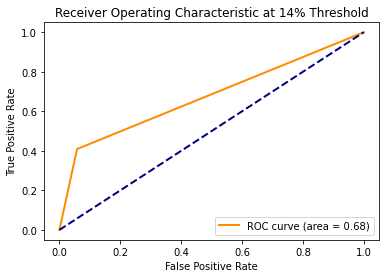

In [71]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to identify the 14% poorest regencies
def identify_poorest_14_percent(df, column):
    threshold = df[column].quantile(0.86)  # 14% poorest
    return (df[column] >= threshold).astype(int)

# Identifying the 14% poorest regencies in both datasets
gdf['rwi_14_percent'] = identify_poorest_14_percent(gdf, 'poorest_percentage_rwi')
gdf['pslm_14_percent'] = identify_poorest_14_percent(gdf, 'poorest_percentage_pslm')

#Calculate TPR and FPR for the 14% threshold
fpr, tpr, _ = roc_curve(gdf['pslm_14_percent'], gdf['rwi_14_percent'])
roc_auc = auc(fpr, tpr)  # Corrected AUROC calculation

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic at 14% Threshold')
plt.legend(loc="lower right")
plt.show()


/Users/kismatkhatri/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Index(['Shape_Leng', 'Shape_Area', 'ADM2_EN', 'ADM2_PCODE', 'ADM2_REF',
       'ADM2ALT1EN', 'ADM2ALT2EN', 'ADM1_EN', 'ADM1_PCODE', 'ADM0_EN',
       'ADM0_PCODE', 'date', 'validOn', 'validTo', 'geometry',
       'poorest_percentage_rwi', 'District', 'poorest_percentage_pslm'],
      dtype='object')


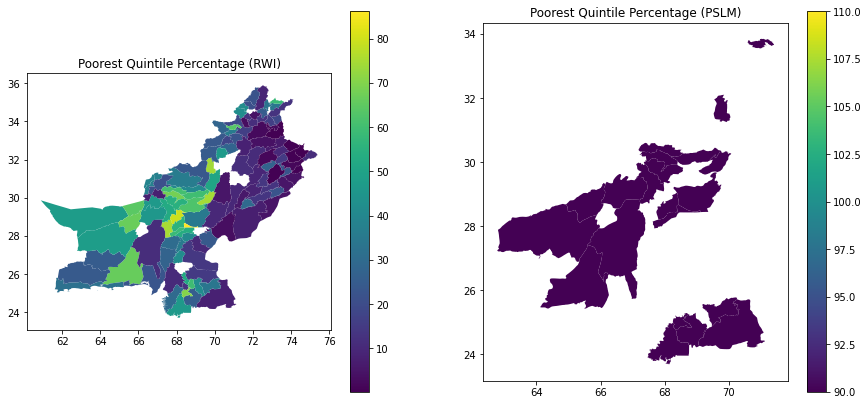

In [77]:

# Function to calculate the percentage of the poorest quintile in each regency
def calculate_poorest_quintile_percentage(df, wealth_column, regency_column):
    df['quintile'] = df[wealth_column].rank(pct=True) // 0.2 + 1
    poorest_df = df[df['quintile'] == 1]
    percentage_df = poorest_df.groupby(regency_column).size() / df.groupby(regency_column).size() * 100
    return percentage_df.reset_index(name='poorest_percentage')

# Calculate the poorest quintile percentage for both RWI and PSLM
rwi_poorest_percentage = calculate_poorest_quintile_percentage(filtered_rwi_district_data, 'rwi_weight', 'ADM2_EN')
PSlm_poorest_percentage = calculate_poorest_quintile_percentage(pslm_district_wealth, 'Wealth_Index1', 'District')



# Assuming districts is your GeoDataFrame with the shapefile data
gdf = districts.merge(rwi_poorest_percentage, how='left', left_on='ADM2_EN', right_on='ADM2_EN')
gdf = gdf.merge(PSlm_poorest_percentage, how='left', left_on='ADM2_EN', right_on='District', suffixes=('_rwi', '_pslm'))

# Check if the columns exist
print(gdf.columns)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
gdf.plot(column='poorest_percentage_rwi', ax=ax[0], legend=True)
ax[0].set_title('Poorest Quintile Percentage (RWI)')
gdf.plot(column='poorest_percentage_pslm', ax=ax[1], legend=True)  # Changed from 'susenas' to 'pslm'
ax[1].set_title('Poorest Quintile Percentage (PSLM)')
plt.show()



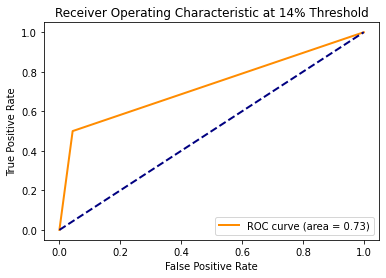

In [73]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to identify the 14% poorest regencies
def identify_poorest_14_percent(df, column):
    threshold = df[column].quantile(0.86)  # 14% poorest
    return (df[column] >= threshold).astype(int)

# Identifying the 14% poorest regencies in both datasets
gdf['rwi_14_percent'] = identify_poorest_14_percent(gdf, 'poorest_percentage_rwi')
gdf['pslm_14_percent'] = identify_poorest_14_percent(gdf, 'poorest_percentage_pslm')

#Calculate TPR and FPR for the 14% threshold
fpr, tpr, _ = roc_curve(gdf['pslm_14_percent'], gdf['rwi_14_percent'])
roc_auc = auc(fpr, tpr)  # Corrected AUROC calculation

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic at 14% Threshold')
plt.legend(loc="lower right")
plt.show()
